In [5]:
import numpy as np
import pandas as pd
import emcee
import scipy.special
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import seaborn as sns
import corner
rc = {'lines.linewidth': 1.5,
      'axes.labelsize' : 14,
      'axes.titlesize' : 18,
      'axes.facecolor' : 'EBEBEB',
      'axes.edgecolor' : '000000',
      'axes.linewidth' : 0.75,
      'axes.frameon' : True,
      'xtick.labelsize' : 11,
      'ytick.labelsize' : 11,
      'font.family' : 'Droid Sans',
      'grid.linestyle' : ':',
      'grid.color' : 'a6a6a6',
      'mathtext.fontset' : 'stixsans',
      'mathtext.sf' : 'sans'}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans') 
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#------------------------------------------------------------------------------- 
%matplotlib notebook

# Non-linear regression.

In order to obtain the MWC parameters given the fold-change measurements Manuel took at MBL and a confidence intereval on such parameters we will use a Bayesian approach to perform a non-linear regression.
Our theoretical model dictates that the fold change in gene expression is given by
\begin{equation}
    fc = \frac{1}{1 + \frac{2R p_{act}(C)}{N_{NS}} \left( 1 + e^{-\beta \Delta \epsilon_{ai}} \right) } e^{-\beta \Delta \epsilon_r},
\end{equation}
where $p_{act}(C)$ is given by
\begin{equation}
    p_{act}(C) = \frac{\left( 1 + C e^{\epsilon_A}\right)^2}{\left( 1 + C e^{\epsilon_A}\right)^2 + e^{-\beta \epsilon_{ai}} \left( 1 + C e^{\epsilon_I}\right)^2}.
\end{equation}

We define $\epsilon_A = -\ln K_A$ and $\epsilon_I = -\ln K_I$ for convenience during the regression.

If we want to fit the parameters $\epsilon_A$ and $\epsilon_I$ by Bayes theorem we have that
\begin{equation}
P(\epsilon_A, \epsilon_I \mid D, I) \propto P(D \mid \epsilon_A, \epsilon_I, I) \cdot P(\epsilon_A, \epsilon_I \mid I),
\end{equation}
where $D$ is the experimental data and $I$ is all the previous information.

## Gaussian likelihood and constant error

The simplest model to perform the regression is to assume the following:
1. each measurement is independent
2. the errors are Gaussian distributed
3. this error is constant along the range of IPTG.

This third assumption can be relaxed further down the road, but for now this is the easiest zero-order approximation we want to implement.

Now it is important to indicate that each element lf $D$ is a "pair" of a dependent variable (the experimental fold change $fc_{exp}$ and the independent variables (the repressor copy number $R$, the binding energy $\Delta \epsilon_r$ and the IPTG concentration $C$). With this in hand we implement the first assumption as
\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, I) = \prod_{i = 1}^n P(fc_{exp}^{(i)} \mid \epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)}, I),
\end{equation}
where $n$ is the number of data points and the superscript $(i)$ indicates the $i$th element of $D$.

Implementing the second and third assumption we obtain
\begin{equation}
P(D \mid \epsilon_A, \epsilon_I, \sigma, I) = \left( 2\pi\sigma^2 \right)^{\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right],
\end{equation}
where we include the parameter $\sigma$ associated with the Gaussian distributed error.

For the priors we can assume that the 3 parameters $\epsilon_A, \epsilon_I$ and $\sigma$ are not only independent, but since they have a uniform prior in log scale they can have a Jeffres' prior, i.e.
\begin{equation}
P(\epsilon_A, \epsilon_I, \sigma \mid I) \equiv \frac{1}{\epsilon_A}\cdot\frac{1}{\epsilon_I}\cdot\frac{1}{\sigma}
\end{equation}

Putting all the pieces together we can compute the posterior distribution as
\begin{equation}
P(\epsilon_A, \epsilon_I, \sigma \mid D, I) \propto \left( 2\pi\sigma^2 \right)^{\frac{n}{2}} \prod_{i = 1}^n \exp \left[ \frac{1}{2 \sigma^2} \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right] \frac{1}{\epsilon_A}\cdot\frac{1}{\epsilon_I}\cdot\frac{1}{\sigma}
\end{equation}

But we are left with the nuance parameter $\sigma$ that we don't care about. To eliminate this parameter we need to marginalize over all values of $\sigma$ as
\begin{equation}
P(\epsilon_A, \epsilon_I \mid D, I) = \int_{- \infty}^\infty d\sigma P(\epsilon_A, \epsilon_I, \sigma \mid D, I).
\end{equation}
And when everything settles down, i.e. after some nasty integration, we find that the posterior is given by the student-t distribution
\begin{equation}
P(\epsilon_A, \epsilon_I \mid D, I) \propto \left[ \sum_{i=1}^n \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right]^{\frac{n}{2}}. 
\end{equation}

To work with the log posterior probability we have that
\begin{equation}
\ln P(\epsilon_A, \epsilon_I \mid D, I) \propto \frac{n}{2} \ln \left[ \sum_{i=1}^n \left( fc_{exp}^{(i)} - fc\left(\epsilon_A, \epsilon_I, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(i)} \right) \right)^2 \right]
\end{equation}

Let's code up the functions to compute the theoretical fold-change

In [6]:
# define a funciton to compute the fold change as a funciton of IPTG
def pact(IPTG, ea, ei, epsilon=4.5):
    '''
    Returns the probability of a repressor being active as described by the MWC
    model.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    Returns
    -------
    pact : float.
        probability of a repressor of being in the active state. Active state is
        defined as the state that can bind to the DNA.
    '''
    pact = (1 + IPTG * np.exp(ea))**2 / \
    ((1 + IPTG * np.exp(ea))**2 + np.exp(-epsilon) * (1 + IPTG * np.exp(ei))**2)
    return pact

def fold_change(IPTG, ea, ei, epsilon, R, epsilon_r):
    '''
    Returns the gene expression fold change according to the thermodynamic model
    with the extension that takes into account the effect of the inducer.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    R : array-like.
        repressor copy number for each of the strains. The length of this array
        should be equal to the IPTG array. If only one value of the repressor is
        given it is asssume that all the data points should be evaluated with
        the same repressor copy number
    epsilon_r : array-like
        repressor binding energy. The length of this array
        should be equal to the IPTG array. If only one value of the binding
        energy is given it is asssume that all the data points 
        should be evaluated with the same repressor copy number
        
    Returns
    -------
    fold-change : float.
        gene expression fold change as dictated by the thermodynamic model.
   '''
    return 1 / (1 + 2 * R / 5E6 * pact(IPTG, ea, ei, epsilon) * \
            (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))

Now let's code up the log posterior

In [7]:
def log_post(param, indep_var, dep_var):
    '''
    Computes the log posterior for a single set of parameters.
    Parameters
    ----------
    param : array-like.
        param[0] = epsilon_a
        ]aram[1] = epsilon_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
        
    Returns
    -------
    log_post : float.
        the log posterior probability
    '''
    # unpack parameters
    ea, ei = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var[:, 0], indep_var[:, 1], indep_var[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = fold_change(IPTG, ea, ei, 4.5, R, epsilon_r)
    
    # return the log posterior
    return -len(dep_var) / 2 * np.log(np.sum((dep_var - fc_theory)**2))

Now it is time to test this! But first let's read the data

<IPython.core.display.Javascript object>


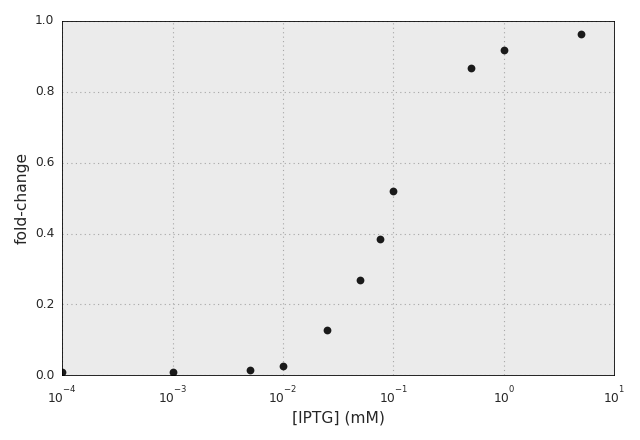

In [29]:
#Load the data. 
data = pd.read_csv('../../data/mbl_2016/MBL_fc_data.csv')

# Let's first try to do the regression using only one RBS and one operator
rbs = data[(data.strain=='1027') & (data.epsilon_r==-13.9) & \
          (data.date==160622)]

plt.figure()
plt.plot(rbs.IPTG, rbs.fold_change, 'ok')
plt.xscale('log')
plt.xlabel('[IPTG] (mM)')
plt.ylabel('fold-change')
plt.tight_layout()

### Plotting the posterior distribution

Before computing the MAP and doing the proper regression, let's look at the posterior itself

<IPython.core.display.Javascript object>


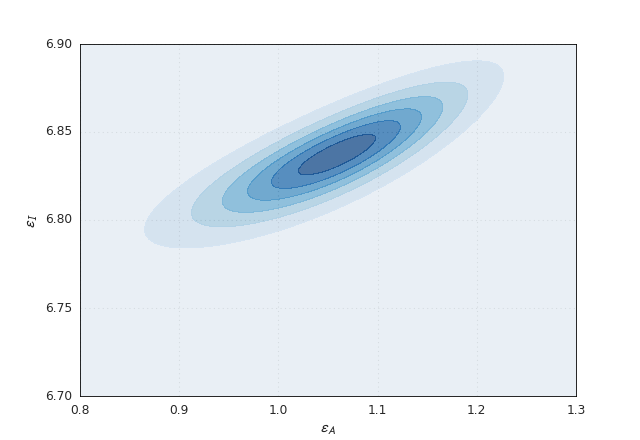

In [36]:
# Parameter values to plot
ea = np.linspace(0.8, 1.3, 100)
ei = np.linspace(6.7, 6.9, 100)

# make a grid to plot
ea_grid, ei_grid = np.meshgrid(ea, ei)

# compute the log posterior
indep_var = rbs[['IPTG', 'repressors', 'epsilon_r']]
dep_var = rbs.fold_change

log_posterior = np.empty_like(ea_grid)
for j in range(len(ea)):
    for i in range(len(ei)):
        log_posterior[i, j] = log_post([ea_grid[i, j], ei_grid[i, j]],
                                       indep_var.values, dep_var.values)

# Get things to scale better
log_posterior -= log_posterior.max()

# plot the results
plt.figure()
plt.contourf(ea_grid, ei_grid, np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)
plt.xlabel(r'$\epsilon_A$')
plt.ylabel(r'$\epsilon_I$')